In [81]:
%matplotlib notebook

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subs2vec.vecs import Vectors
from scipy.stats import ttest_rel, pearsonr, spearmanr
from os import listdir

sns.set(style='whitegrid', palette='Set2')

# Materials

In [82]:
# load materials
df_materials = pd.read_csv('materials.tsv', sep='\t').dropna()
df_materials.columns = df_materials.columns.str.lower()
df_materials['stimulus'] = df_materials['stimulus'].str.replace('.', '').str.lower()
display(df_materials)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  after removing the cwd from sys.path.


,itemnum,pic_sent,plaus_implaus,stimulus,list,agent,verb,patient,agent_start,agent_end,action_start,action_end,patient_start,patient_end
0,1,sent,plaus,the cop is arresting the criminal,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
1,1,sent,implaus,the criminal is arresting the cop,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
2,2,sent,plaus,the babysitter is scolding the child,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
3,2,sent,implaus,the child is scolding the babysitter,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
4,3,sent,plaus,the doctor is using a stethoscope on the patient,2,2.0,6.0,9.0,1.0,2.0,3.0,7.0,8.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,38,sent,implaus,the princess is measuring the tailor,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
76,39,sent,plaus,the lifeguard is saving the grandmother,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
77,39,sent,implaus,the grandmother is saving the lifeguard,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0
78,40,sent,plaus,the chauffeur is opening the door for the lady,1,2.0,6.0,9.0,1.0,2.0,3.0,7.0,8.0,9.0


In [72]:
# load embeddings
vecs = Vectors('../embeddings/wiki-subs.en.1e6.vec')
#vecs = Vectors('../embeddings/cc.en.300.vec')
#vecs = Vectors('../embeddings/fic.en.vec')

[INFO] loading vectors ../embeddings/wiki-subs.en.1e6.vec
[INFO] <function Vectors.__init__ at 0x7fb83d815560> ran in 77.072 seconds


## Contrast agent-verb similarity in plausible versus implausible sentences
Because implausible sentences were created by switching agent-patient roles in plausible sentences, the agent-verb similarities are identical to patient-verb similarities in the implausible sentences (and vice-versa).

In [83]:
def phrase_similarity(df, sentence_col, a_cols, b_cols, method='word2vec', model=None, tokenizer=None):
    
    norm = lambda x: x / np.linalg.norm(x)
    cos = lambda a, b: np.dot(norm(a), norm(b))
    
    def get_cols(cols):
        if len(cols) == 1:
            # return column indices
            return [slice(int(idx) - 1, int(idx)) for idx in df[cols].values]
        elif len(cols) == 2:
            # return list of slices
            return [slice(int(row[cols[0]]) - 1, int(row[cols[1]])) for _, row in df.iterrows()]
        else:
            # raise error
            raise ValueError('invalid number of columns passed, pass a list or tuple containing one or two column names')
    
    if method.lower() == 'word2vec':
        vecs_dict = model.as_dict()
        def get_vec(word):
            return vecs_dict.get(word, np.zeros(300))
        
        # split sentences
        sentences = [sentence.split(' ') for sentence in df[sentence_col].values]
        
        # convert column names to lists of words
        a_phrases = [sentences[i][idx] for i, idx in enumerate(get_cols(a_cols))]
        b_phrases = [sentences[i][idx] for i, idx in enumerate(get_cols(b_cols))]
        
        # convert lists of words to mean vectors
        a_vecs = [np.mean([get_vec(word) for word in phrase], axis=0) for phrase in a_phrases]
        b_vecs = [np.mean([get_vec(word) for word in phrase], axis=0) for phrase in b_phrases]
        
        # return cosine similarities
        return [cos(a_vecs[i], b_vecs[i]) for i in range(len(sentences))]

    elif method.lower() == 'bert':
        
        def tokenize(sentences, tokenizer):
            token_dict = tokenizer(sentences, padding=True, return_tensors='pt')
            tokens = [tokenizer.tokenize(sentence) for sentence in sentences]
            token_lengths = [[len(tokenizer.tokenize(word)) for word in sentence.split(' ')] for sentence in sentences]
            token_lengths = [tokens + [1] for tokens in token_lengths]
            return token_dict, tokens, token_lengths
        
        def translate_cols(cols, token_lengths):
            for i, col in enumerate(cols):
                start = np.sum(token_lengths[i][:col.start])
                end = np.sum(token_lengths[i][:col.stop + 1]) - 1
                cols[i] = slice(int(start), int(end))
            return cols
        
        def cos_tensor(tensor, a_slice, b_slice):
            a_phrase = torch.sum(tensor[a_slice, -4:], dim=(0, 1))
            b_phrase = torch.sum(tensor[b_slice, -4:], dim=(0, 1))
            return cos(a_phrase, b_phrase)
        
        # tokenize
        token_dict, tokens, token_lengths = tokenize(list(df[sentence_col]), tokenizer)
        model.eval;  # evaluation mode
        with torch.no_grad():  # do not draw full graph
            # feed tokens into model
            outputs = model(**token_dict)
            # get hidden layer activations
            activations = torch.stack(outputs[2], dim=0).permute(1,2,0,3)
        
        a_cols = translate_cols(get_cols(a_cols), token_lengths)
        b_cols = translate_cols(get_cols(b_cols), token_lengths)
        
        return [cos_tensor(tensor, a_cols[i], b_cols[i]) for i, tensor in enumerate(activations)]
    else:
        raise ValueError('method not recognized, use either "word2vec" or "bert"')

In [84]:
# compute agent-verb distance
df_materials['agent_verb_cosine'] = phrase_similarity(df_materials,
                                                      'stimulus',
                                                      ['agent_start', 'agent_end'],
                                                      ['action_start', 'action_end'],
                                                      model=vecs)

# compute patient-verb distance
df_materials['patient_verb_cosine'] = phrase_similarity(df_materials,
                                                        'stimulus',
                                                        ['patient_start', 'patient_end'],
                                                        ['action_start', 'action_end'],
                                                        model=vecs)

display(df_materials)

[INFO] <function Vectors.as_dict at 0x7fb83d815830> ran in 10.321 seconds
[INFO] <function Vectors.as_dict at 0x7fb83d815830> ran in 0.742 seconds


,itemnum,pic_sent,plaus_implaus,stimulus,list,agent,verb,patient,agent_start,agent_end,action_start,action_end,patient_start,patient_end,agent_verb_cosine,patient_verb_cosine
0,1,sent,plaus,the cop is arresting the criminal,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.458020,0.517957
1,1,sent,implaus,the criminal is arresting the cop,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.517957,0.458020
2,2,sent,plaus,the babysitter is scolding the child,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.468419,0.403798
3,2,sent,implaus,the child is scolding the babysitter,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.403798,0.468419
4,3,sent,plaus,the doctor is using a stethoscope on the patient,2,2.0,6.0,9.0,1.0,2.0,3.0,7.0,8.0,9.0,0.564161,0.605933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,38,sent,implaus,the princess is measuring the tailor,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.243684,0.298824
76,39,sent,plaus,the lifeguard is saving the grandmother,2,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.368287,0.345896
77,39,sent,implaus,the grandmother is saving the lifeguard,1,2.0,4.0,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.345896,0.368287
78,40,sent,plaus,the chauffeur is opening the door for the lady,1,2.0,6.0,9.0,1.0,2.0,3.0,7.0,8.0,9.0,0.503949,0.522470


In [85]:
# any items for which we don't have word embeddings will return NaN and be excluded from plots and tests
display(df_materials[df_materials['agent_verb_cosine'].isna()])

,itemnum,pic_sent,plaus_implaus,stimulus,list,agent,verb,patient,agent_start,agent_end,action_start,action_end,patient_start,patient_end,agent_verb_cosine,patient_verb_cosine


### Visual comparison

<IPython.core.display.Javascript object>


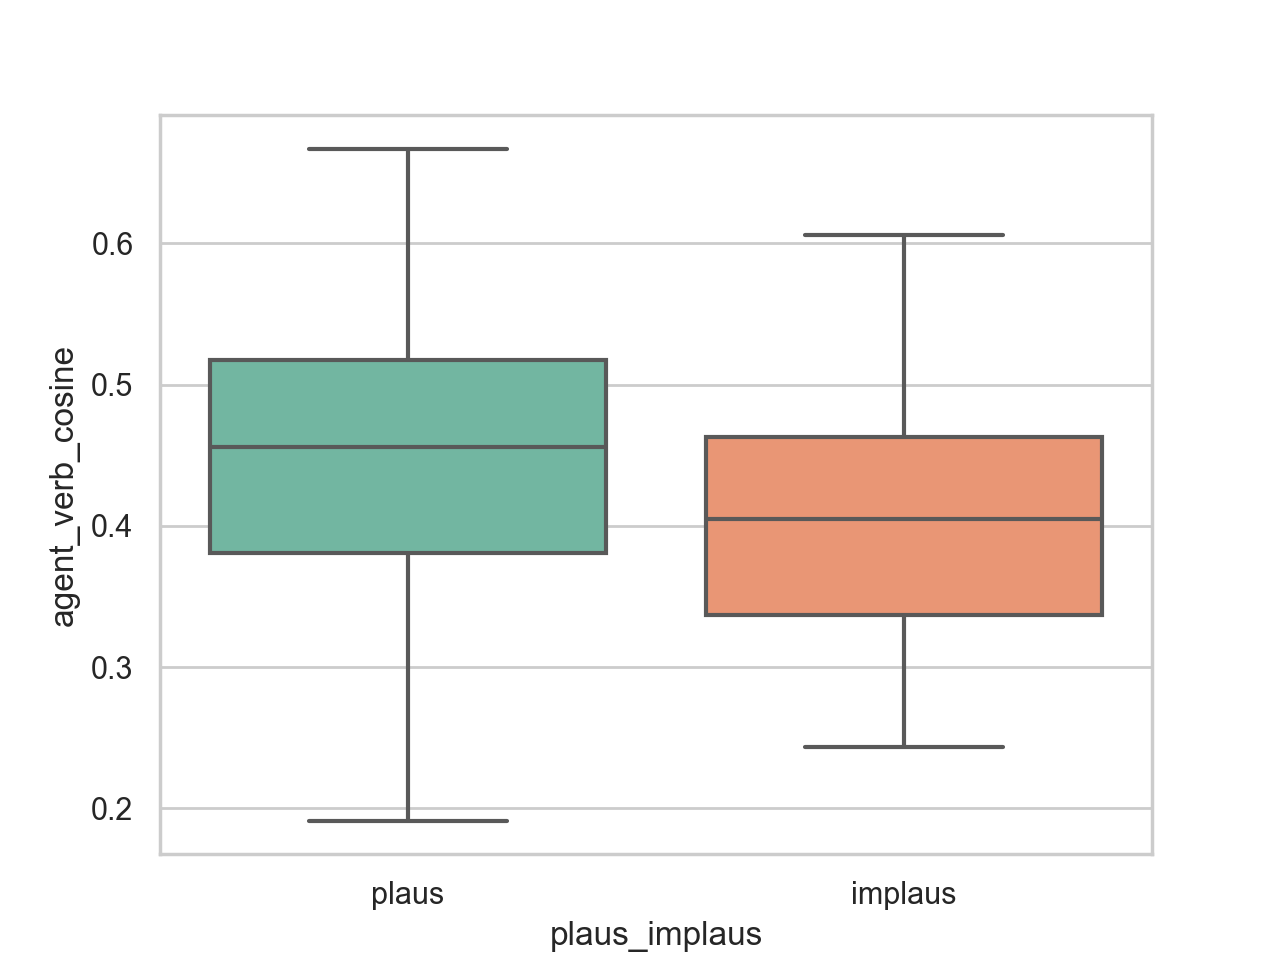

In [86]:
# quick plot
g = sns.boxplot(data=df_materials.dropna(), x='plaus_implaus', y='agent_verb_cosine')

### Statistical comparison

In [87]:
# paired samples t-test
df_test = df_materials.dropna()
t = ttest_rel(df_test.loc[df_test['plaus_implaus'] == 'plaus', 'agent_verb_cosine'],
          df_test.loc[df_test['plaus_implaus'] == 'implaus', 'agent_verb_cosine'],
          nan_policy='omit')
print(f'Paired samples t-statistic: {t[0]:.2f}, p-value: {t[1]:.2f}')

Paired samples t-statistic: 2.67, p-value: 0.01


## Contrast difference between agent-verb similarity and patient-verb similarity in plausible versus implausible sentences

In [88]:
# compute plausibility difference between agent- and patient-attachment
df_materials['plausibility_diff'] = df_materials['agent_verb_cosine'] - df_materials['patient_verb_cosine']

### Visual comparison

<IPython.core.display.Javascript object>


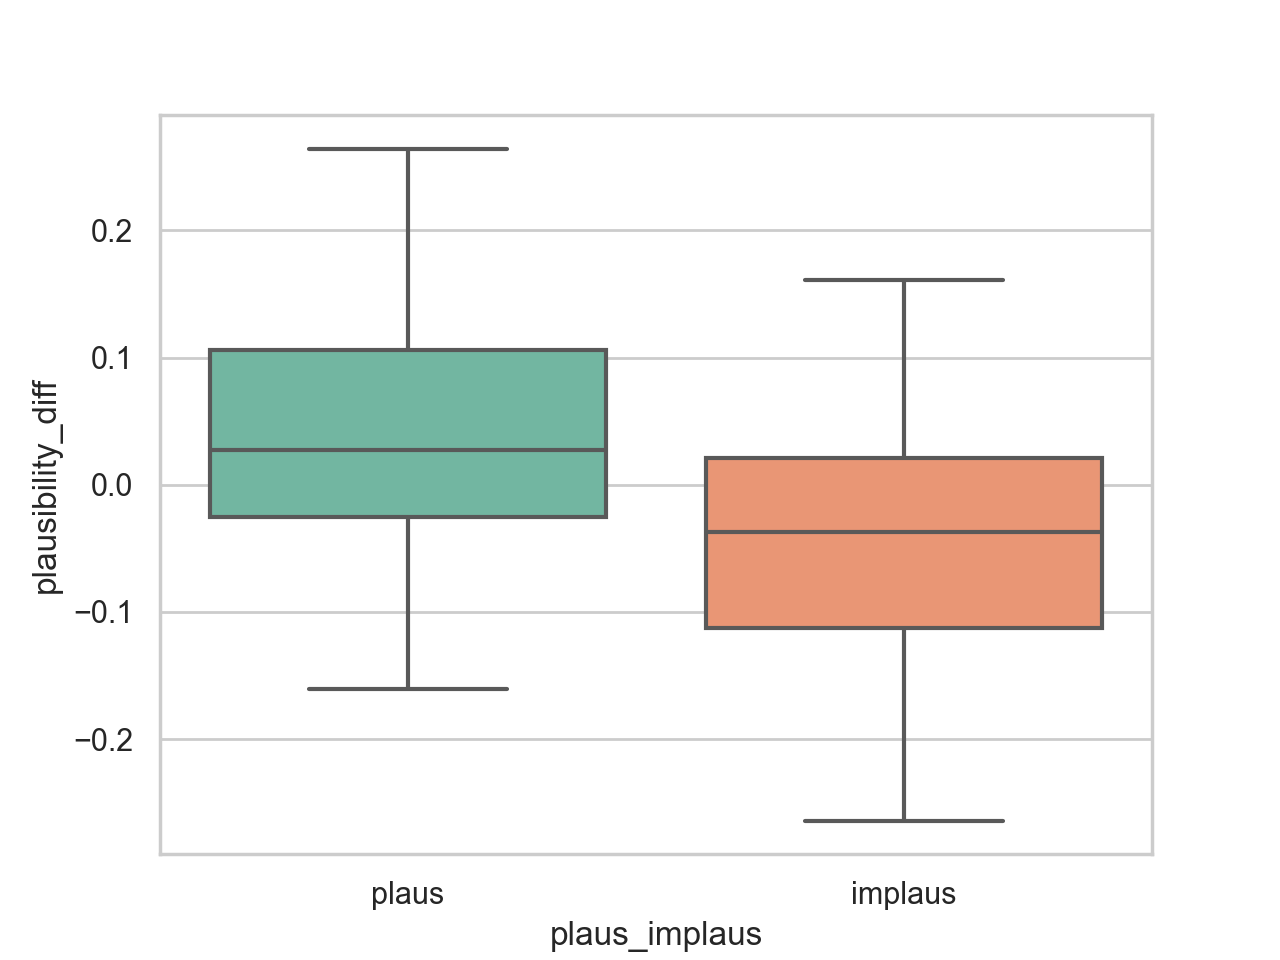

In [89]:
# quick plot
g = sns.boxplot(data=df_materials.dropna(), x='plaus_implaus', y='plausibility_diff')

### Statistical comparison

In [90]:
# paired samples t-test
df_test = df_materials.dropna()
t = ttest_rel(df_test.loc[df_test['plaus_implaus'] == 'plaus', 'plausibility_diff'],
          df_test.loc[df_test['plaus_implaus'] == 'implaus', 'plausibility_diff'],
          nan_policy='omit')
print(f'Paired samples t-statistic: {t[0]:.2f}, p-value: {t[1]:.2f}')

Paired samples t-statistic: 2.54, p-value: 0.02


# Correlate similarities with behavioral data

In [91]:
# load behavioral data
dfs = [pd.read_csv('data/' + fname) for fname in listdir('data/')]
df_controls = pd.concat(dfs)
df_controls.columns = df_controls.columns.str.lower()
df_controls = df_controls.loc[df_controls['condition'] == 'Sent_Sem']
df_controls['item'] = df_controls['item'].str.replace('.', '').str.lower()

display(df_controls)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  


,subjid,list,order,run,trialnumber,trialonset,condition,itemnum,item,motion,correctanswer,response,accuracy,rt
11,FED_20190320a_3T2,2,2,2,12,46,Sent_Sem,4,the grandmother is rescuing the fireman,right,2,0,0,0.000000
12,FED_20190320a_3T2,2,2,2,13,48,Sent_Sem,11,the lion is pouncing on the safari guide,right,1,2,0,0.497588
13,FED_20190320a_3T2,2,2,2,14,50,Sent_Sem,33,the boss is yelling at the worker,right,1,2,0,0.063568
14,FED_20190320a_3T2,2,2,2,15,52,Sent_Sem,6,the girl is frightening the ghost,right,2,1,0,1.614897
15,FED_20190320a_3T2,2,2,2,16,54,Sent_Sem,7,the mother is feeding the baby,left,1,1,1,1.818027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,FED_20160519a_3T1,1,1,1,58,166,Sent_Sem,17,the woman is biting the vampire,left,2,0,0,0.000000
58,FED_20160519a_3T1,1,1,1,59,168,Sent_Sem,8,the artist is painting the businessman,right,1,1,1,1.036093
59,FED_20160519a_3T1,1,1,1,60,170,Sent_Sem,39,the grandmother is saving the lifeguard,right,2,2,1,1.417967
60,FED_20160519a_3T1,1,1,1,61,172,Sent_Sem,4,the fireman is rescuing the grandmother,left,1,1,1,1.230064


In [92]:
df = df_controls.merge(df_materials, left_on='item', right_on='stimulus', how='left')
display(df)

,subjid,list_x,order,run,trialnumber,trialonset,condition,itemnum_x,item,motion,...,patient,agent_start,agent_end,action_start,action_end,patient_start,patient_end,agent_verb_cosine,patient_verb_cosine,plausibility_diff
0,FED_20190320a_3T2,2,2,2,12,46,Sent_Sem,4,the grandmother is rescuing the fireman,right,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.326796,0.407453,-0.080657
1,FED_20190320a_3T2,2,2,2,13,48,Sent_Sem,11,the lion is pouncing on the safari guide,right,...,8.0,1.0,2.0,3.0,5.0,6.0,8.0,0.454462,0.419358,0.035104
2,FED_20190320a_3T2,2,2,2,14,50,Sent_Sem,33,the boss is yelling at the worker,right,...,7.0,1.0,2.0,3.0,5.0,6.0,7.0,0.471873,0.375377,0.096496
3,FED_20190320a_3T2,2,2,2,15,52,Sent_Sem,6,the girl is frightening the ghost,right,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.433689,0.560691,-0.127002
4,FED_20190320a_3T2,2,2,2,16,54,Sent_Sem,7,the mother is feeding the baby,left,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.400575,0.434630,-0.034055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,FED_20160519a_3T1,1,1,1,58,166,Sent_Sem,17,the woman is biting the vampire,left,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.337694,0.454366,-0.116672
956,FED_20160519a_3T1,1,1,1,59,168,Sent_Sem,8,the artist is painting the businessman,right,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.622556,0.358371,0.264186
957,FED_20160519a_3T1,1,1,1,60,170,Sent_Sem,39,the grandmother is saving the lifeguard,right,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.345896,0.368287,-0.022392
958,FED_20160519a_3T1,1,1,1,61,172,Sent_Sem,4,the fireman is rescuing the grandmother,left,...,6.0,1.0,2.0,3.0,4.0,5.0,6.0,0.407453,0.326796,0.080657


## Trial-level response accuracy

### Accuracy and agent-verb similarity

In [93]:
# compare participant accuracy to embedding distances
df_test = df.dropna()
r = pearsonr(df_test['agent_verb_cosine'], df_test['accuracy'])
rank_r = spearmanr(df_test['agent_verb_cosine'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.05, p-value: 0.09
Spearman r: 0.06, p-value: 0.07


### Accuracy and patient-verb similarity

In [94]:
# compare participant accuracy to embedding distances
r = pearsonr(df_test['patient_verb_cosine'], df_test['accuracy'])
rank_r = spearmanr(df_test['patient_verb_cosine'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.03, p-value: 0.37
Spearman r: 0.05, p-value: 0.16


### Accuracy and difference between agent-verb and patient-verb similarity

In [95]:
# compare participant accuracy to plausibility diff
r = pearsonr(df_test['plausibility_diff'], df_test['accuracy'])
rank_r = spearmanr(df_test['plausibility_diff'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.02, p-value: 0.49
Spearman r: 0.02, p-value: 0.53


## Mean response accuracy

### Accuracy and agent-verb similarity

In [106]:
# compare aggregated accuracy to embedding distances
df_test = df.dropna()
df_test = df_test.groupby(['item', 'plaus_implaus']).mean().reset_index()
r = pearsonr(df_test['agent_verb_cosine'], df_test['accuracy'])
rank_r = spearmanr(df_test['agent_verb_cosine'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.23, p-value: 0.04
Spearman r: 0.26, p-value: 0.02


### Accuracy and patient-verb similarity

In [107]:
# compare aggregated accuracy to embedding distances
r = pearsonr(df_test['patient_verb_cosine'], df_test['accuracy'])
rank_r = spearmanr(df_test['patient_verb_cosine'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.14, p-value: 0.23
Spearman r: 0.21, p-value: 0.06


### Accuracy and difference between agent-verb and patient-verb similarity

In [108]:
# compare aggregated accuracy to plausibility diff
r = pearsonr(df_test['plausibility_diff'], df_test['accuracy'])
rank_r = spearmanr(df_test['plausibility_diff'], df_test['accuracy'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.10, p-value: 0.40
Spearman r: 0.09, p-value: 0.42


### Mean participant accuracy plotted over agent-verb similarity

<IPython.core.display.Javascript object>


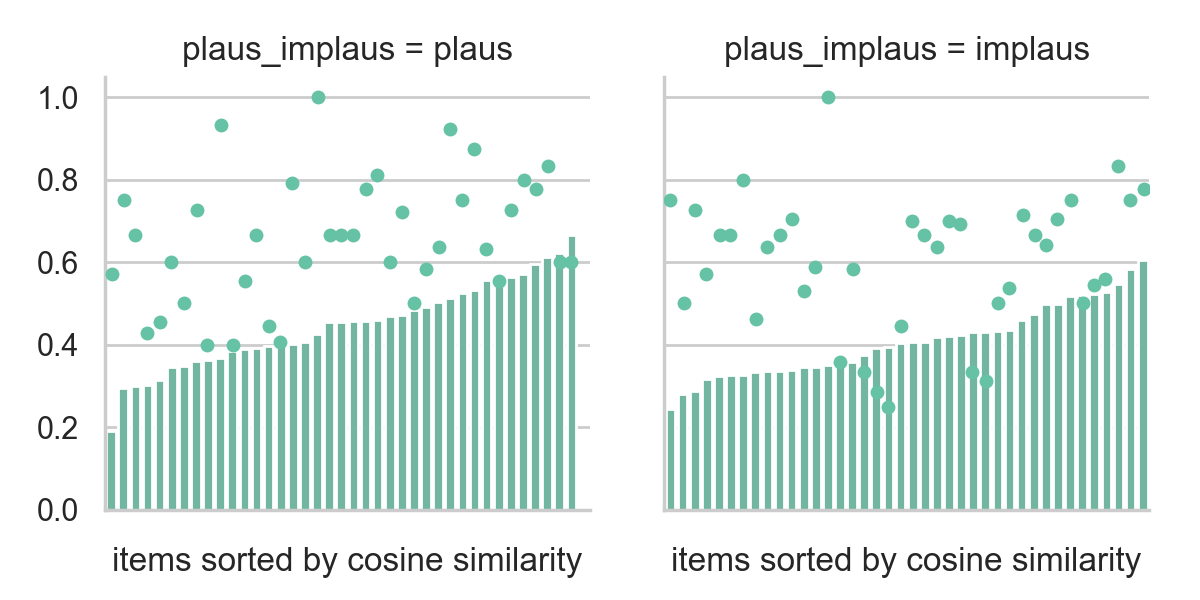

In [109]:
df_test['itemcode'] = df_test['itemnum_x'].astype(str)
df_test = df_test.sort_values('agent_verb_cosine')
g = sns.FacetGrid(df_test,
                  col='plaus_implaus')
g.map_dataframe(sns.barplot, x='itemcode', y='agent_verb_cosine')
g.map_dataframe(sns.stripplot, x='itemcode', y='accuracy')
g.set(xticklabels=[], xlabel='items sorted by cosine similarity')

## Trial-level response time

### Response time and agent-verb similarity

In [100]:
# compare response time to embedding distances
df_test = df.dropna()
df_test = df_test[df_test['accuracy'] == 1]
r = pearsonr(df_test['agent_verb_cosine'], df_test['rt'])
rank_r = spearmanr(df_test['agent_verb_cosine'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: -0.01, p-value: 0.77
Spearman r: -0.00, p-value: 0.98


### Response time and patient-verb similarity

In [101]:
# compare response time to embedding distances
r = pearsonr(df_test['patient_verb_cosine'], df_test['rt'])
rank_r = spearmanr(df_test['patient_verb_cosine'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.00, p-value: 0.95
Spearman r: 0.01, p-value: 0.82


### Response time and difference between agent-verb similarity and patient-verb similarity

In [102]:
# compare response time to plausibility diff
r = pearsonr(df_test['plausibility_diff'], df_test['rt'])
rank_r = spearmanr(df_test['plausibility_diff'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: -0.01, p-value: 0.72
Spearman r: -0.02, p-value: 0.69


## Mean response time

### Response time and agent-verb similarity

In [103]:
# compare response time to embedding distances
df_test = df.dropna()
df_test = df_test[df_test['accuracy'] == 1]
df_test = df_test.groupby(['item', 'plaus_implaus']).mean().reset_index()
r = pearsonr(df_test['agent_verb_cosine'], df_test['rt'])
rank_r = spearmanr(df_test['agent_verb_cosine'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: -0.02, p-value: 0.84
Spearman r: -0.05, p-value: 0.67


### Response time and patient-verb similarity

In [104]:
# compare response time to embedding distances
r = pearsonr(df_test['patient_verb_cosine'], df_test['rt'])
rank_r = spearmanr(df_test['patient_verb_cosine'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: -0.09, p-value: 0.43
Spearman r: -0.10, p-value: 0.39


### Response time and difference between agent-verb similarity and patient-verb similarity

In [105]:
# compare response time to plausibility diff
r = pearsonr(df_test['plausibility_diff'], df_test['rt'])
rank_r = spearmanr(df_test['plausibility_diff'], df_test['rt'])
print(f'Pearson r: {r[0]:.2f}, p-value: {r[1]:.2f}')
print(f'Spearman r: {rank_r[0]:.2f}, p-value: {rank_r[1]:.2f}')

Pearson r: 0.07, p-value: 0.55
Spearman r: 0.03, p-value: 0.79
